
=== Intrinsic single-qubit separability (predict qi from qubit-i readout only) ===
Qubit 1: accuracy = 0.713
Qubit 2: accuracy = 0.818
Qubit 3: accuracy = 0.802
Qubit 4: accuracy = 0.814

=== Pairwise dependence matrices (i <- j) ===
Mean-shift matrix:
 [[0.726 0.042 0.066 0.07 ]
 [0.034 0.853 0.026 0.036]
 [0.032 0.01  0.815 0.037]
 [0.064 0.032 0.044 0.866]]
Mahalanobis-shift matrix:
 [[1.022 0.062 0.079 0.089]
 [0.051 1.661 0.045 0.064]
 [0.041 0.016 1.496 0.045]
 [0.125 0.062 0.085 1.597]]
Permutation-test p-values (Mahalanobis):
 [[0.0033 0.0033 0.0033 0.0033]
 [0.0066 0.0033 0.0166 0.0033]
 [0.0332 0.6246 0.0033 0.0133]
 [0.0033 0.0066 0.0033 0.0033]]


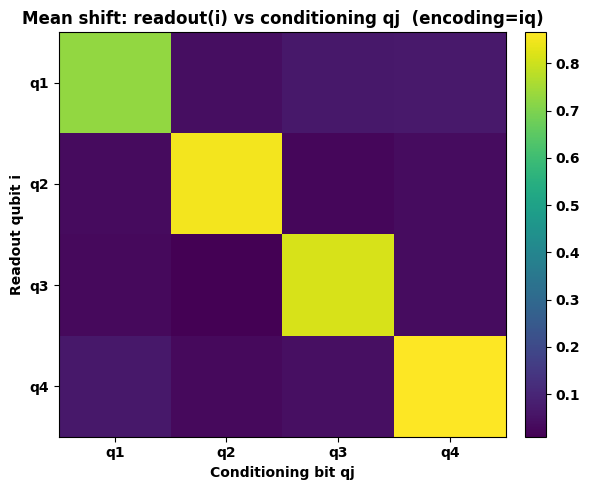

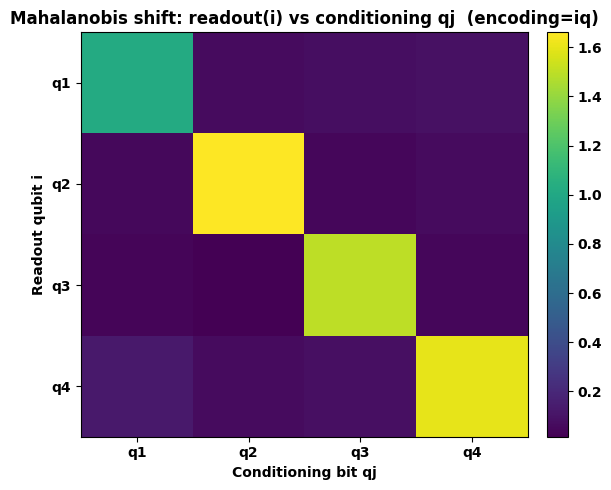

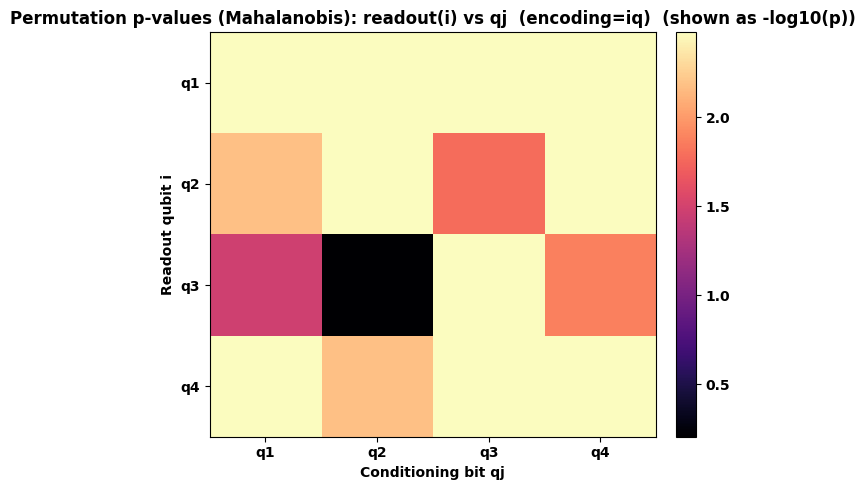

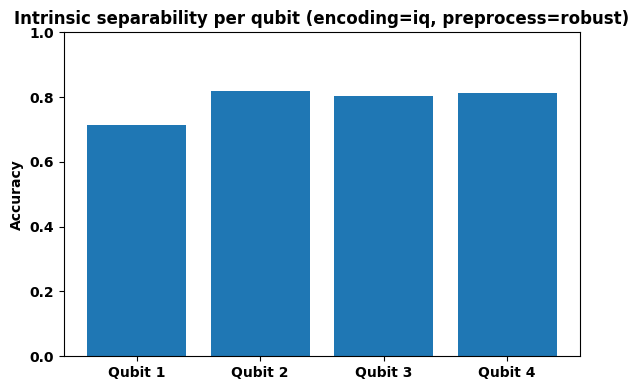

In [1]:
"""
Diagnose intrinsic overlap vs. inter-qubit readout dependence (cross-talk)
from existing 4-qubit IQ readout dataset.

Data:
  - dataset_X.txt : (N,4) complex (one complex readout per qubit per shot)
  - dataset_y.txt : (N,4) bits [q1,q2,q3,q4]

Goals:
  1) For each pair (i <- j): quantify how readout of qubit i changes when bit qj flips.
     This is a data-driven proxy for readout cross-talk / correlations.
  2) For each qubit i: quantify how well its own readout separates qi=0 vs qi=1
     (intrinsic overlap of the two clouds for that qubit).
  3) Provide permutation-test p-values to assess significance of detected dependencies.

Output:
  - Heatmaps for pairwise dependence metrics (mean shift, Mahalanobis distance, p-values)
  - Per-qubit intrinsic separability metrics
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from scipy.linalg import pinv
from scipy.stats import norm


# -------------------------------
# Load dataset
# -------------------------------
def load_dataset(X_path="dataset_X.txt", y_path="dataset_y.txt"):
    X = np.loadtxt(X_path, dtype=complex)  # (N,4)
    y = np.loadtxt(y_path, dtype=int)      # (N,4)
    return X, y


# -------------------------------
# Feature encoding for a single qubit readout
# -------------------------------
def qubit_features(X_complex, qubit_index, encoding="iq"):
    """
    Return 2D features for one qubit:
      encoding='iq'    -> [I, Q]
      encoding='angle' -> [|z|, angle(z)]
    Shape: (N,2)
    """
    z = X_complex[:, qubit_index]

    if encoding == "iq":
        return np.column_stack([z.real, z.imag])

    if encoding == "angle":
        return np.column_stack([np.abs(z), np.angle(z)])

    raise ValueError("encoding must be 'iq' or 'angle'")


# -------------------------------
# Simple robust whitening (optional)
# -------------------------------
def robust_center_scale(X2):
    """
    Robust centering and scaling per dimension using median and IQR.
    Good for IQ clouds with outliers.
    """
    med = np.median(X2, axis=0)
    q75 = np.percentile(X2, 75, axis=0)
    q25 = np.percentile(X2, 25, axis=0)
    iqr = np.maximum(q75 - q25, 1e-9)
    return (X2 - med) / iqr


# -------------------------------
# Dependence metrics: p(r_i | q_j=0) vs p(r_i | q_j=1)
# -------------------------------
def mean_shift_metric(A, B):
    """
    Euclidean distance between means of two 2D clouds A and B.
    """
    muA = A.mean(axis=0)
    muB = B.mean(axis=0)
    return float(np.linalg.norm(muA - muB))


def mahalanobis_between_means(A, B):
    """
    Mahalanobis distance between means using pooled covariance.
    More scale-aware than plain mean shift.
    """
    muA = A.mean(axis=0)
    muB = B.mean(axis=0)
    # pooled covariance
    CA = np.cov(A.T, bias=False)
    CB = np.cov(B.T, bias=False)
    C = 0.5 * (CA + CB)
    Cinv = pinv(C)  # stable inverse
    d = muA - muB
    return float(np.sqrt(d.T @ Cinv @ d))


def permutation_test_stat(A, B, stat_fn, n_perm=500, seed=0):
    """
    Permutation test for difference between two groups using stat_fn.
    Returns: (observed_stat, p_value)
    """
    rng = np.random.default_rng(seed)
    A = np.asarray(A)
    B = np.asarray(B)

    obs = stat_fn(A, B)

    X = np.vstack([A, B])
    nA = len(A)
    count = 0
    for _ in range(n_perm):
        idx = rng.permutation(len(X))
        Aperm = X[idx[:nA]]
        Bperm = X[idx[nA:]]
        s = stat_fn(Aperm, Bperm)
        if s >= obs:
            count += 1

    # add-one smoothing
    p = (count + 1) / (n_perm + 1)
    return obs, p


# -------------------------------
# Intrinsic overlap proxy for each qubit: can we predict qi from its own readout?
# -------------------------------
def intrinsic_separability_single_qubit(X_complex, y_bits, qubit_index, encoding="iq",
                                       preprocess="robust", test_size=0.25, seed=42):
    """
    Train a simple classifier using only qubit i 2D features to predict qi (0/1).
    This estimates how separable the two clouds are for that qubit alone.
    """
    X2 = qubit_features(X_complex, qubit_index, encoding=encoding)
    if preprocess == "robust":
        X2 = robust_center_scale(X2)

    y = y_bits[:, qubit_index]

    Xtr, Xte, ytr, yte = train_test_split(
        X2, y, test_size=test_size, random_state=seed, stratify=y
    )

    clf = LogisticRegression(max_iter=2000)
    clf.fit(Xtr, ytr)
    pred = clf.predict(Xte)
    acc = accuracy_score(yte, pred)

    return float(acc)


# -------------------------------
# Main diagnostic
# -------------------------------
def diagnose(X_path="dataset_X.txt", y_path="dataset_y.txt",
             encoding="iq", preprocess="robust",
             n_perm=300, seed=0, make_plots=True):
    """
    Build pairwise dependence matrices and intrinsic separability metrics.
    """
    Xc, yb = load_dataset(X_path, y_path)
    n_qubits = 4

    # Matrices: i <- j
    mean_shift = np.zeros((n_qubits, n_qubits), float)
    maha_shift = np.zeros((n_qubits, n_qubits), float)
    pvals_maha = np.ones((n_qubits, n_qubits), float)

    # For each pair (i <- j), compare readout of i conditioned on qj=0 vs qj=1
    for i in range(n_qubits):
        Xi = qubit_features(Xc, i, encoding=encoding)
        if preprocess == "robust":
            Xi = robust_center_scale(Xi)

        for j in range(n_qubits):
            # skip trivial self-conditioning? (still informative, but you can keep)
            qj = yb[:, j]
            A = Xi[qj == 0]
            B = Xi[qj == 1]

            # Ensure enough samples
            if len(A) < 50 or len(B) < 50:
                mean_shift[i, j] = np.nan
                maha_shift[i, j] = np.nan
                pvals_maha[i, j] = np.nan
                continue

            mean_shift[i, j] = mean_shift_metric(A, B)
            obs_maha, p_maha = permutation_test_stat(
                A, B, stat_fn=mahalanobis_between_means, n_perm=n_perm, seed=seed + 13*i + j
            )
            maha_shift[i, j] = obs_maha
            pvals_maha[i, j] = p_maha

    # Intrinsic separability for each qubit (predict qi from its own readout only)
    intrinsic_acc = []
    for i in range(n_qubits):
        acc = intrinsic_separability_single_qubit(
            Xc, yb, i, encoding=encoding, preprocess=preprocess
        )
        intrinsic_acc.append(acc)
    intrinsic_acc = np.array(intrinsic_acc)

    # Print summary
    print("\n=== Intrinsic single-qubit separability (predict qi from qubit-i readout only) ===")
    for i, acc in enumerate(intrinsic_acc, start=1):
        print(f"Qubit {i}: accuracy = {acc:.3f}")

    print("\n=== Pairwise dependence matrices (i <- j) ===")
    print("Mean-shift matrix:\n", np.round(mean_shift, 3))
    print("Mahalanobis-shift matrix:\n", np.round(maha_shift, 3))
    print("Permutation-test p-values (Mahalanobis):\n", np.round(pvals_maha, 4))

    # Plots
    if make_plots:
        labels = [f"q{idx+1}" for idx in range(n_qubits)]

        def heatmap(M, title, cmap="viridis", vmin=None, vmax=None, log_p=False):
            plt.figure(figsize=(6, 5))
            A = M.copy()
            if log_p:
                # show -log10(p)
                A = -np.log10(np.clip(A, 1e-12, 1.0))
                title = title + "  (shown as -log10(p))"
            im = plt.imshow(A, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
            plt.xticks(range(n_qubits), labels)
            plt.yticks(range(n_qubits), labels)
            plt.colorbar(im, fraction=0.046, pad=0.04)
            plt.title(title)
            plt.xlabel("Conditioning bit qj")
            plt.ylabel("Readout qubit i")
            plt.tight_layout()
            plt.show()

        heatmap(mean_shift, f"Mean shift: readout(i) vs conditioning qj  (encoding={encoding})")
        heatmap(maha_shift, f"Mahalanobis shift: readout(i) vs conditioning qj  (encoding={encoding})")
        heatmap(pvals_maha, f"Permutation p-values (Mahalanobis): readout(i) vs qj  (encoding={encoding})",
                cmap="magma", log_p=True)

        # Bar plot for intrinsic separability
        plt.figure(figsize=(6, 4))
        plt.bar(range(1, n_qubits+1), intrinsic_acc)
        plt.ylim(0.0, 1.0)
        plt.xticks(range(1, n_qubits+1), [f"Qubit {i}" for i in range(1, n_qubits+1)])
        plt.ylabel("Accuracy")
        plt.title(f"Intrinsic separability per qubit (encoding={encoding}, preprocess={preprocess})")
        plt.tight_layout()
        plt.show()

    return mean_shift, maha_shift, pvals_maha, intrinsic_acc


if __name__ == "__main__":
    # You can switch encoding to "angle" later:
    #   encoding="angle"
    diagnose(
        X_path="dataset_X.txt",
        y_path="dataset_y.txt",
        encoding="iq",
        preprocess="robust",
        n_perm=300,
        seed=0,
        make_plots=True
    )
